In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from keras import regularizers

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix , classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_dir = "D:/fayl_ckachat/archive/test"
test_dir = "D:/fayl_ckachat/archive/train"

#original size of the image
img_height = 48
img_width = 48

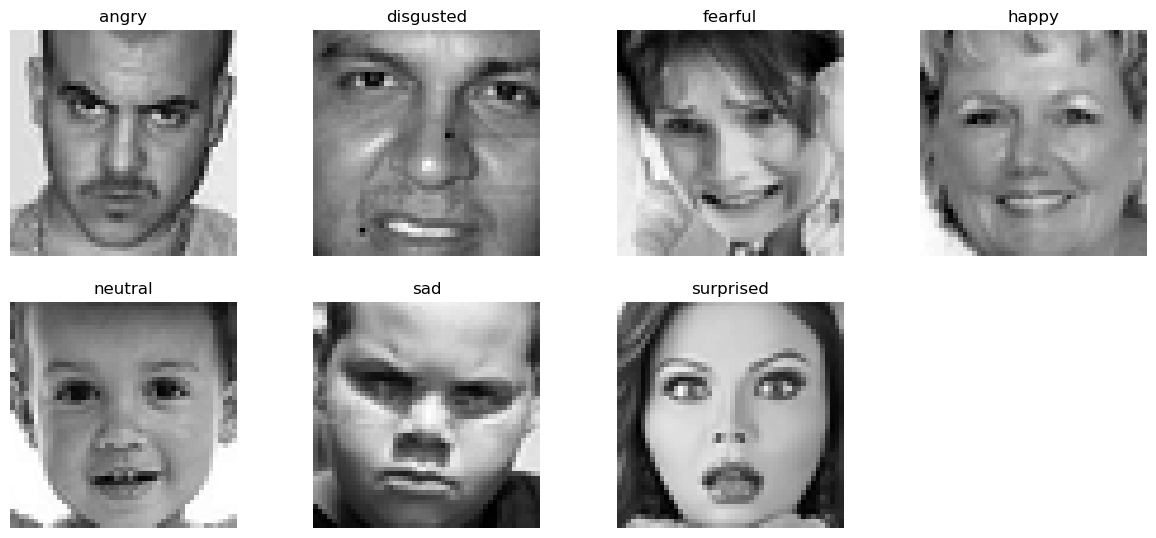

In [37]:
emotions=os.listdir(train_dir)
plt.figure(figsize=(15,10))
for i,emotion in enumerate(emotions,1):
    folder=os.path.join(train_dir,emotion)
    img_path=os.path.join(folder,os.listdir(folder)[6])
    img=plt.imread(img_path)
    plt.subplot(3,4,i)
    plt.imshow(img,cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [38]:
# Data Augmentation

train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.5)

In [39]:
# Applying data augmentation to the images as we read them from their respectivve directories

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_height,img_width),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = train_dir,
                                                              target_size = (img_height,img_width),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                        target_size = (img_height,img_width),
                                                        batch_size = 64,
                                                        shuffle  = False , 
                                                        color_mode = "grayscale",
                                                        class_mode = "categorical",
                                                        seed = 12
                                                             )

Found 5746 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.


In [40]:
model= Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [41]:
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,496,903 (17.15 MB)

 Trainable params: 4,492,935 (17.14 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [42]:
epochs = 60
batch_size = 64

history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator)

Epoch 1/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 69s 715ms/step - accuracy: 0.1454 - loss: 9.8638 - val_accuracy: 0.0349 - val_loss: 9.1609
Epoch 2/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 66s 732ms/step - accuracy: 0.1907 - loss: 9.4901 - val_accuracy: 0.1439 - val_loss: 9.3156
Epoch 3/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 67s 747ms/step - accuracy: 0.2145 - loss: 9.1524 - val_accuracy: 0.1480 - val_loss: 9.1474
Epoch 4/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 68s 748ms/step - accuracy: 0.2040 - loss: 8.9280 - val_accuracy: 0.1837 - val_loss: 9.4271
Epoch 5/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 69s 765ms/step - accuracy: 0.2173 - loss: 8.6373 - val_accuracy: 0.2696 - val_loss: 8.5907
Epoch 6/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 64s 712ms/step - accuracy: 0.2182 - loss: 8.4042 - val_accuracy: 0.2786 - val_loss: 8.2279
Epoch 7/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 695ms/step - accuracy: 0.2389 - loss: 8.1528 - val_accuracy: 0.2598 - val_loss: 8.0022
Epoch 8/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 694ms/step - accuracy: 0.2414 - loss: 7.9004 - val_accu

In [17]:
model.save('model_optimal.h5')


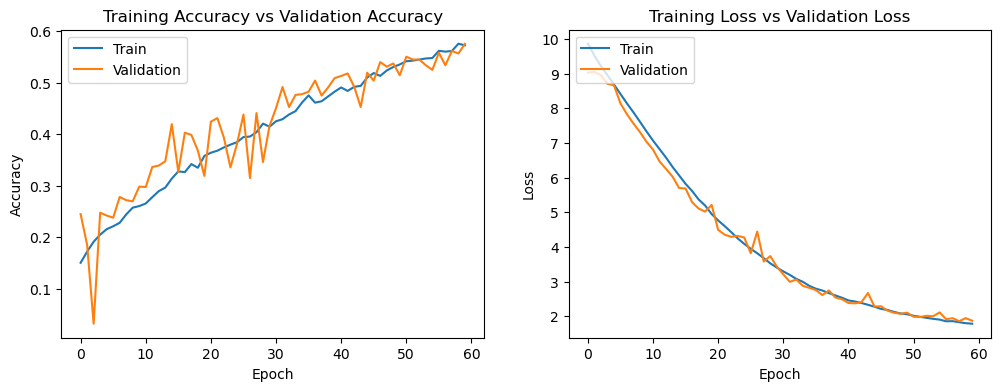

In [18]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [22]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\Lenovo\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\Lenovo\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\Lenovo\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13564\906543593.py", line 1, in <module>

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 425, in evaluate

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 161, in one_step_on_iterator

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 150, in one_step_on_data

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 81, in test_step

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\trainers\trainer.py", line 316, in compute_loss

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\trainers\compile_utils.py", line 609, in __call__

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\trainers\compile_utils.py", line 645, in call

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\losses\loss.py", line 42, in __call__

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\losses\losses.py", line 22, in call

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\losses\losses.py", line 1576, in categorical_crossentropy

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\ops\nn.py", line 1482, in categorical_crossentropy

  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 589, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[64,8] labels_size=[64,7]
	 [[{{node compile_loss/categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_one_step_on_iterator_89871]

In [21]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

NameError: name 'y_test' is not defined